# Week 4 — Transformer Encoder Benchmark (PyTorch + sklearn)

**Goal:** Train a self-contained Transformer Encoder on a **text classification** task using sklearn's **20 Newsgroups** dataset (4 categories, ~4 700 documents) and compare five hyper-parameter configurations.

| Step | Description |
|------|-------------|
| 1 | Build a multi-head Transformer Encoder from scratch in PyTorch |
| 2 | Load 20 Newsgroups (4 categories), tokenise with a simple word-level vocabulary |
| 3 | Run five experiments varying learning-rate and batch-size |
| 4 | Visualise training curves, compare results, and report test metrics |

In [1]:
import math, re, random, collections
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# ── reproducibility ──────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.set_num_threads(2)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)

device: cpu


## 1. Transformer Encoder (from scratch, PyTorch)

A minimal but correct multi-head self-attention Transformer Encoder with:
- Learned token + positional embeddings
- Layer-norm → Multi-Head Attention → residual
- Layer-norm → Feed-Forward → residual

In [2]:
# ── Multi-Head Self-Attention ─────────────────────────────────
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.Wo = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        B, T, D = x.shape
        q = self.Wq(x).view(B, T, self.heads, self.d_k).transpose(1, 2)
        k = self.Wk(x).view(B, T, self.heads, self.d_k).transpose(1, 2)
        v = self.Wv(x).view(B, T, self.heads, self.d_k).transpose(1, 2)
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn = self.drop(torch.softmax(scores, dim=-1))
        out = (attn @ v).transpose(1, 2).contiguous().view(B, T, D)
        return self.Wo(out)


# ── Feed-Forward Block ───────────────────────────────────────
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


# ── Single Encoder Layer ─────────────────────────────────────
class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, heads, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x


# ── Full Encoder Stack ───────────────────────────────────────
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, heads, d_ff, dropout=0.1, max_len=512):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, d_model)
        self.layers = nn.ModuleList(
            [EncoderLayer(d_model, heads, d_ff, dropout) for _ in range(n_layers)]
        )
        self.norm = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        B, T = x.shape
        pos = torch.arange(T, device=x.device).unsqueeze(0)
        h = self.drop(self.tok_emb(x) + self.pos_emb(pos))
        for layer in self.layers:
            h = layer(h)
        return self.norm(h)


# Quick sanity check
_demo = Encoder(5002, 64, 2, 4, 128)
print(f"Encoder params (V=5002, d=64, L=2, h=4): {sum(p.numel() for p in _demo.parameters()):,}")
del _demo

Encoder params (V=5002, d=64, L=2, h=4): 419,968


## 2. Dataset — sklearn `fetch_20newsgroups` (4 categories)

We pick **4 distinct newsgroup categories** to keep the dataset small (~4 700 docs) and training fast.

**Tokenisation:** lowercase → split on non-alpha → keep the top-5 000 most frequent words → map to integer ids. Sequences are truncated/padded to a fixed length of **128 tokens**.

| Property | Value |
|----------|-------|
| Categories | sci.space, rec.sport.hockey, talk.politics.guns, comp.graphics |
| Total docs | ~4 700 |
| Max sequence length | 128 |
| Vocab size | 5 002 (5 000 words + PAD + UNK) |
| Classes | 4 |

In [3]:
# ── Load 20 Newsgroups (4 categories) ────────────────────────
CATEGORIES = ["sci.space", "rec.sport.hockey",
              "talk.politics.guns", "comp.graphics"]

news = fetch_20newsgroups(subset="all", categories=CATEGORIES,
                          remove=("headers", "footers", "quotes"),
                          random_state=SEED)
texts = news.data
labels = news.target
label_names = news.target_names

print(f"Total documents: {len(texts)}")
print(f"Classes: {label_names}")
print(f"Class distribution: {dict(zip(label_names, np.bincount(labels)))}")

# ── Simple word-level tokeniser ──────────────────────────────
PAD_IDX = 0
UNK_IDX = 1
MAX_VOCAB = 5_000
MAX_LEN = 128

def tokenise_text(text: str) -> list[str]:
    """Lowercase, keep only alphabetic tokens."""
    return re.findall(r"[a-z]+", text.lower())

# Build vocabulary from all data (top-MAX_VOCAB words)
counter = collections.Counter()
for doc in texts:
    counter.update(tokenise_text(doc))

vocab = {w: i + 2 for i, (w, _) in enumerate(counter.most_common(MAX_VOCAB))}
VOCAB_SIZE = len(vocab) + 2  # +2 for PAD and UNK

def encode(text: str) -> list[int]:
    return [vocab.get(w, UNK_IDX) for w in tokenise_text(text)]

def pad_or_truncate(ids: list[int], length: int) -> list[int]:
    return (ids[:length] + [PAD_IDX] * length)[:length]

X_enc = np.array([pad_or_truncate(encode(t), MAX_LEN) for t in texts], dtype=np.int64)
y_enc = labels.astype(np.int64)

NUM_CLASSES = len(label_names)
SEQ_LEN = MAX_LEN

# ── Train / Val / Test split (60 / 20 / 20) ─────────────────
x_train_full, x_test, y_train_full, y_test = train_test_split(
    X_enc, y_enc, test_size=0.20, random_state=SEED, stratify=y_enc,
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.25, random_state=SEED, stratify=y_train_full,
)

print(f"\nvocab_size={VOCAB_SIZE}  num_classes={NUM_CLASSES}  seq_len={SEQ_LEN}")
print(f"train={x_train.shape[0]}  val={x_val.shape[0]}  test={x_test.shape[0]}")

# Quick peek: first 3 documents (truncated)
for i in range(3):
    print(f"\n[{label_names[labels[i]]}] {texts[i][:120].strip()}…")

Total documents: 3869
Classes: ['comp.graphics', 'rec.sport.hockey', 'sci.space', 'talk.politics.guns']
Class distribution: {'comp.graphics': np.int64(973), 'rec.sport.hockey': np.int64(999), 'sci.space': np.int64(987), 'talk.politics.guns': np.int64(910)}

vocab_size=5002  num_classes=4  seq_len=128
train=2321  val=774  test=774

[talk.politics.guns] [... snip ...]


Can you imagine what happens when a magazine explodes? Bullets go flying every
where. IMHO, these "guns…

[talk.politics.guns] time

No, Lt Calley was later acquitted. His troops killed 400-500
people, including kids, elderly and women... I sure d…

[sci.space] …


## 3. Model Definition & Training Utilities

`EncoderClassifier` uses **mean-pooling** over non-padding positions, which works better than first-token pooling for naturally tokenised text (no special CLS token).

In [4]:
class EncoderClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, pad_idx=0,
                 d_model=64, n_layers=2, heads=4, d_ff=128,
                 dropout=0.1, max_len=512):
        super().__init__()
        self.pad_idx = pad_idx
        self.encoder = Encoder(vocab_size, d_model, n_layers, heads,
                               d_ff, dropout, max_len)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        h = self.encoder(x)                          # (B, T, D)
        mask = (x != self.pad_idx).unsqueeze(-1).float()  # (B, T, 1)
        pooled = (h * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        return self.head(pooled)


# ── DataLoader helper ────────────────────────────────────────
def make_loader(x_arr, y_arr, batch_size, shuffle=False):
    ds = TensorDataset(
        torch.tensor(x_arr, dtype=torch.long),
        torch.tensor(y_arr, dtype=torch.long),
    )
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)


# ── Evaluation ───────────────────────────────────────────────
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, n = 0.0, 0
    all_true, all_pred = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        total_loss += criterion(logits, yb).item() * xb.size(0)
        n += xb.size(0)
        all_true.append(yb.cpu().numpy())
        all_pred.append(logits.argmax(1).cpu().numpy())
    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)
    return {
        "loss": total_loss / n,
        "acc": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="macro"),
        "y_true": y_true,
        "y_pred": y_pred,
    }


# ── Training loop (returns per-epoch history) ────────────────
def train_experiment(name, lr, batch_size, epochs=20):
    torch.manual_seed(SEED)
    model = EncoderClassifier(
        vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES, pad_idx=PAD_IDX
    ).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    crit = nn.CrossEntropyLoss()

    train_loader = make_loader(x_train, y_train, batch_size, shuffle=True)
    val_loader   = make_loader(x_val,   y_val,   256)

    history = []
    for ep in range(1, epochs + 1):
        model.train()
        ep_loss, ep_n = 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
            ep_loss += loss.item() * xb.size(0)
            ep_n += xb.size(0)

        scheduler.step()
        val = evaluate(model, val_loader, crit)
        history.append({
            "epoch": ep,
            "train_loss": ep_loss / ep_n,
            "val_loss": val["loss"],
            "val_acc": val["acc"],
            "val_f1": val["f1"],
        })

    best_val_acc = max(h["val_acc"] for h in history)
    print(f"  [{name}] best_val_acc={best_val_acc:.4f}  "
          f"final_val_acc={history[-1]['val_acc']:.4f}")
    return model, history, best_val_acc

## 4. Hyperparameter Experiments

We sweep **learning rate** and **batch size** while keeping architecture fixed (d_model=64, 2 layers, 4 heads, 15 epochs, cosine LR schedule).

In [5]:
EPOCHS = 15

experiments = [
    {"name": "baseline",    "lr": 1e-3,  "batch_size": 64},
    {"name": "low_lr",      "lr": 1e-4,  "batch_size": 64},
    {"name": "high_lr",     "lr": 5e-3,  "batch_size": 64},
    {"name": "small_batch", "lr": 1e-3,  "batch_size": 16},
    {"name": "large_batch", "lr": 1e-3,  "batch_size": 256},
]

rows = []
histories = {}
trained_models = {}

for cfg in experiments:
    print(f"▸ Running {cfg['name']} (lr={cfg['lr']}, bs={cfg['batch_size']}) …")
    model, hist, best_val = train_experiment(
        cfg["name"], cfg["lr"], cfg["batch_size"], epochs=EPOCHS
    )
    trained_models[cfg["name"]] = model
    histories[cfg["name"]] = hist
    final = hist[-1]
    rows.append({
        "name": cfg["name"],
        "lr": cfg["lr"],
        "batch_size": cfg["batch_size"],
        "best_val_acc": best_val,
        "final_val_loss": final["val_loss"],
        "final_val_acc": final["val_acc"],
        "final_val_f1": final["val_f1"],
    })

results_df = (
    pd.DataFrame(rows)
    .sort_values("best_val_acc", ascending=False)
    .reset_index(drop=True)
)
results_df.style.highlight_max(subset=["best_val_acc", "final_val_acc", "final_val_f1"],
                                color="lightgreen")

▸ Running baseline (lr=0.001, bs=64) …
  [baseline] best_val_acc=0.7765  final_val_acc=0.7739
▸ Running low_lr (lr=0.0001, bs=64) …
  [low_lr] best_val_acc=0.4664  final_val_acc=0.4612
▸ Running high_lr (lr=0.005, bs=64) …
  [high_lr] best_val_acc=0.8682  final_val_acc=0.8656
▸ Running small_batch (lr=0.001, bs=16) …
  [small_batch] best_val_acc=0.8217  final_val_acc=0.8152
▸ Running large_batch (lr=0.001, bs=256) …
  [large_batch] best_val_acc=0.6047  final_val_acc=0.6008


,name,lr,batch_size,best_val_acc,final_val_loss,final_val_acc,final_val_f1
0,high_lr,0.005000,64,0.868217,0.491297,0.865633,0.866433
1,small_batch,0.001000,16,0.821705,0.540997,0.815245,0.814131
2,baseline,0.001000,64,0.776486,0.621661,0.773902,0.772949
3,large_batch,0.001000,256,0.604651,0.981419,0.600775,0.597723
4,low_lr,0.000100,64,0.466408,1.316329,0.461240,0.455838


## 5. Training Curves & Comparison

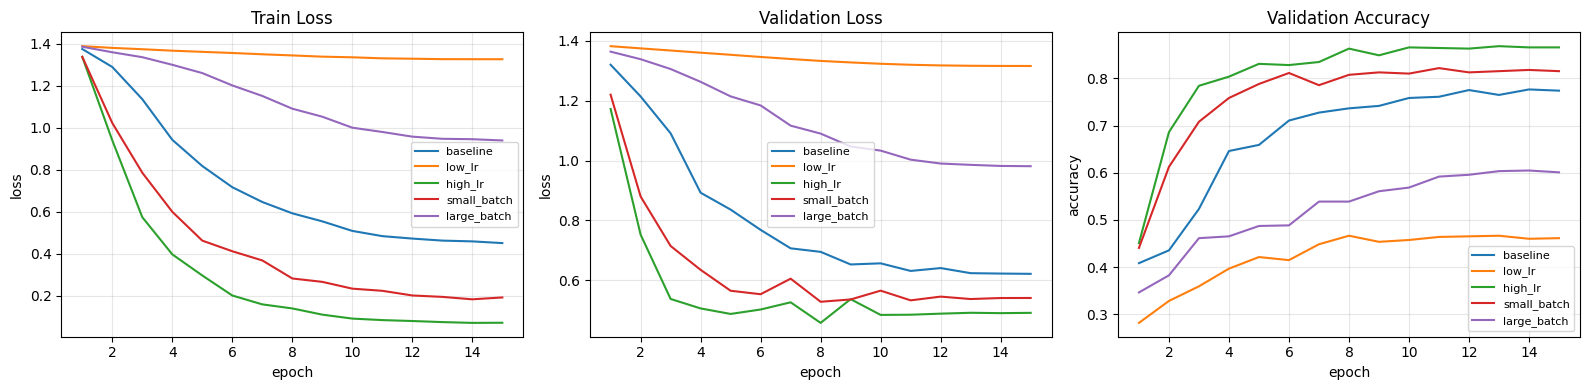

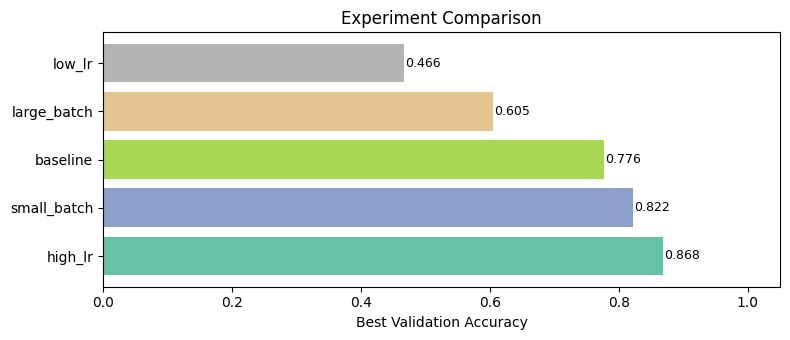

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for name, hist in histories.items():
    epochs = [h["epoch"] for h in hist]
    axes[0].plot(epochs, [h["train_loss"] for h in hist], label=name)
    axes[1].plot(epochs, [h["val_loss"]   for h in hist], label=name)
    axes[2].plot(epochs, [h["val_acc"]    for h in hist], label=name)

for ax, title, ylabel in zip(
    axes,
    ["Train Loss", "Validation Loss", "Validation Accuracy"],
    ["loss", "loss", "accuracy"],
):
    ax.set_title(title)
    ax.set_xlabel("epoch")
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ── Bar chart of best val accuracy ───────────────────────────
fig, ax = plt.subplots(figsize=(8, 3.5))
colors = plt.cm.Set2(np.linspace(0, 1, len(results_df)))
bars = ax.barh(results_df["name"], results_df["best_val_acc"], color=colors)
ax.set_xlabel("Best Validation Accuracy")
ax.set_title("Experiment Comparison")
for bar, val in zip(bars, results_df["best_val_acc"]):
    ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height() / 2,
            f"{val:.3f}", va="center", fontsize=9)
ax.set_xlim(0, 1.05)
plt.tight_layout()
plt.show()

## 6. Test Evaluation (best model)

Pick the experiment with the highest validation accuracy and evaluate it on the held-out **test set**.

Best experiment : high_lr
Test loss       : 0.7099
Test accuracy   : 0.8191
Test F1 (macro) : 0.8187

                    precision    recall  f1-score   support

     comp.graphics     0.8710    0.8308    0.8504       195
  rec.sport.hockey     0.8689    0.8950    0.8818       200
         sci.space     0.7202    0.7970    0.7566       197
talk.politics.guns     0.8293    0.7473    0.7861       182

          accuracy                         0.8191       774
         macro avg     0.8223    0.8175    0.8187       774
      weighted avg     0.8223    0.8191    0.8195       774



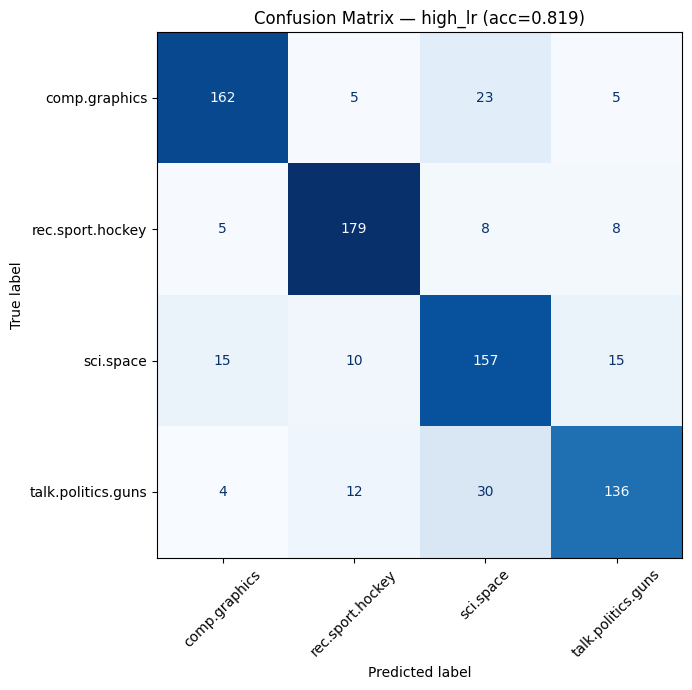

In [7]:
best_name = results_df.loc[0, "name"]
best_model = trained_models[best_name]
criterion = nn.CrossEntropyLoss()
test_loader = make_loader(x_test, y_test, batch_size=256)

test = evaluate(best_model, test_loader, criterion)

print(f"Best experiment : {best_name}")
print(f"Test loss       : {test['loss']:.4f}")
print(f"Test accuracy   : {test['acc']:.4f}")
print(f"Test F1 (macro) : {test['f1']:.4f}")
print()
print(classification_report(test["y_true"], test["y_pred"],
                            target_names=label_names, digits=4))

# ── Confusion Matrix ─────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 7))
cm = confusion_matrix(test["y_true"], test["y_pred"])
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)
ax.set_title(f"Confusion Matrix — {best_name} (acc={test['acc']:.3f})")
plt.tight_layout()
plt.show()